In [ ]:
## ref:https://mp.weixin.qq.com/s/AJmVF1mRYQcuG73iKmkWQg

In [ ]:
# library(optparse)
# op_list <- list(
# make_option(c("-l", "--input_loom"), type = "character", default = NULL, action = "store", help = "The input of aucell loom file",metavar="rds"),
# make_option(c("-m", "--input_meta"), type = "character", default = NULL, action = "store", help = "The metadata of Seurat object",metavar="idents"),
# make_option(c("-c", "--celltype"), type = "character", default = NULL, action = "store", help = "The colname of metadata to calculate RSS",metavar="label")
# )
# parser <- OptionParser(option_list = op_list)
# opt = parse_args(parser)

In [ ]:
options(warn = -1)
getwd()

library(Seurat)
library(SCopeLoomR)
library(AUCell)
library(SCENIC)
library(dplyr)
library(KernSmooth)
library(RColorBrewer)
library(plotly)
library(BiocParallel)

In [2]:
getwd()

[1] "/data/work/02.result/others/ST_NC/01.script"

In [3]:
setwd('../02.result/05.scenic')

In [4]:
# loom <- open_loom(opt$input_loom)
loom <- open_loom('./step2.result/aucell.loom')
loom

Class: H5File
Filename: /data/work/02.result/others/ST_NC/02.result/05.scenic/step2.result/aucell.loom
Access type: H5F_ACC_RDONLY
Attributes: last_modified
Listing:
       name    obj_type  dataset.dims dataset.type_class
      attrs   H5I_GROUP          <NA>               <NA>
  col_attrs   H5I_GROUP          <NA>               <NA>
 col_graphs   H5I_GROUP          <NA>               <NA>
     layers   H5I_GROUP          <NA>               <NA>
     matrix H5I_DATASET 50000 x 10000          H5T_FLOAT
  row_attrs   H5I_GROUP          <NA>               <NA>
 row_graphs   H5I_GROUP          <NA>               <NA>

In [6]:
regulons_incidMat <- get_regulons(loom, column.attr.name="Regulons") # 提取调控元件（regulons）的矩阵 (regulons_incidMat)
regulons <- regulonsToGeneLists(regulons_incidMat)                   # 将提取到的调控元件矩阵 (regulons_incidMat) 转换为基因列表
regulonAUC <- get_regulons_AUC(loom,column.attr.name='RegulonsAUC')  # 提取每个调控元件的 AUC（曲线下面积）值(量化调控元件在细胞中的活动水平)。column.attr.name='RegulonsAUC'  AUC 列属性名
regulonAucThresholds <- get_regulon_thresholds(loom)                 # 提取调控元件的阈值，这些阈值用于区分调控元件在不同细胞中的活跃程度
close_loom(loom)

## 查看loom信息and格式

In [18]:
class(regulons_incidMat)
dim(regulons_incidMat)
head(regulons_incidMat)

[1] "matrix" "array"

[1]    15 10000

PLEKHN1 ISG15 SAMD11 PERM1 HES4 RNF223 TTLL10 TNFRSF18 SCNN1D TAS1R3 ⋯
ELF5(+)  0       0     0      0     0    0      0      0        0      0      ⋯
ERG(+)   0       0     0      0     0    0      0      0        0      0      ⋯
FOXA1(+) 0       0     0      0     0    0      0      0        0      0      ⋯
FOXI1(+) 0       0     0      0     0    0      0      0        0      0      ⋯
HOXB5(+) 0       1     0      0     0    0      0      0        0      0      ⋯
IRF6(+)  0       0     0      0     0    0      0      0        0      0      ⋯
         AC096642.2 NAV2-AS3 AC063948.1 AC079949.5 AL133313.1 AP001429.1
ELF5(+)  0          0        0          0          0          0         
ERG(+)   0          0        0          0          0          0         
FOXA1(+) 0          0        0          0          0          0         
FOXI1(+) 0          0        0          0          0          0         
HOXB5(+) 0          0        0          0          0          0         
IRF6(+)  0          0        0          0          0          0         
         PCDHGC5 PRR18 AC092198.1 IGHV3-11
ELF5(+)  0       0     0          0       
ERG(+)   0       0     0          0       
FOXA1(+) 0       0     0          0       
FOXI1(+) 0       0     0          0       
HOXB5(+) 0       0     0          0       
IRF6(+)  0       0     0          0

In [9]:
class(regulons)
length(regulons)
head(regulons[[1]])

[1] "list"

[1] 15

[1] "PADI2"   "PLA2G2F" "CAMK2N1" "ASAP3"   "NCMAP"   "RIMKLA"

In [10]:
regulons

$`ELF5(+)`
  [1] "PADI2"      "PLA2G2F"    "CAMK2N1"    "ASAP3"      "NCMAP"     
  [6] "RIMKLA"     "ELOVL1"     "CYP4X1"     "PDZK1IP1"   "TACSTD2"   
 [11] "CLCA4"      "EPHX4"      "TMEM56"     "CHI3L2"     "ATP1A1"    
 [16] "VTCN1"      "FLG2"       "RPTN"       "LCE5A"      "SPRR2E"    
 [21] "IVL"        "S100A8"     "SPRR1A"     "PGLYRP4"    "SPRR2F"    
 [26] "EFNA1"      "RAB25"      "ATP1B1"     "ADORA1"     "C1orf115"  
 [31] "CALML5"     "CELF2"      "RASSF4"     "IDE"        "PLEKHS1"   
 [36] "ABLIM1"     "PNLIPRP3"   "LINC00867"  "SAA1"       "SAA2-SAA4" 
 [41] "SAA2"       "MUC15"      "ELF5"       "CTSD"       "SCGB2A1"   
 [46] "SLC37A2"    "BARX2"      "TMEM45B"    "A2ML1"      "PLBD1"     
 [51] "DGAT2"      "HEPHL1"     "CARD18"     "ENDOU"      "KRT80"     
 [56] "KRT78"      "KRT4"       "KRT8"       "KRT18"      "SDR9C7"    
 [61] "GLTP"       "GJB6"       "GJB2"       "TBC1D4"     "LMO7"      
 [66] "CLDN10"     "CLDN10-AS1" "NDRG2"      "SLC39A2"    "TGM1"      
 [71] "SORD"       "TNFAIP8L3"  "MYO5C"      "GCOM1"      "RAB11A"    
 [76] "RHCG"       "SYNM"       "CERS3"      "ALDH1A3"    "PRSS27"    
 [81] "HS3ST2"     "ABCC11"     "CX3CL1"     "CSNK2A2"    "CES3"      
 [86] "HSD17B2"    "ALOX12B"    "RNF222"     "STAC2"      "PPP1R1B"   
 [91] "KRT23"      "SP6"        "LINC01152"  "KRT19"      "DSG2"      
 [96] "DTNA"       "SLC14A1"    "SERPINB12"  "SERPINB7"   "INSR"      
[101] "CASP14"     "EPHX3"      "CYP4F22"    "CNFN"       "LIPE-AS1"  
[106] "PSG5"       "CD177"      "KCNN4"      "LYPD5"      "C5AR2"     
[111] "KLK5"       "KLK10"      "KLK7"       "KLK6"       "KLK8"      
[116] "KLK13"      "VSIG10L"    "TTYH1"      "TNNT1"      "EPS8L1"    
[121] "ZNF865"     "MBOAT2"     "QPCT"       "BCYRN1"     "ATP6V1B1"  
[126] "IL36RN"     "DHRS9"      "LINC01090"  "GPR1"       "MAP2"      
[131] "IGFBP2"     "DIRC3-AS1"  "CXCR2"      "C2orf54"    "TGM3"      
[136] "WFDC5"      "WFDC2"      "CDH22"      "APCDD1L"    "TMPRSS2"   
[141] "PDE9A"      "TMEM211"    "SLC5A1"     "BPIFC"      "SOX10"     
[146] "CMTM6"      "LTF"        "TMEM45A"    "UPK1B"      "CSTA"      
[151] "ROPN1B"     "MRAS"       "AADAC"      "SPTSSB"     "S100P"     
[156] "PROM1"      "COX7B2"     "NIPAL1"     "CNGA1"      "HOPX"      
[161] "TMPRSS11D"  "TMPRSS11F"  "SHROOM3"    "HPSE"       "DAPP1"     
[166] "GRIA2"      "NPY1R"      "MSMO1"      "RGS7BP"     "PIK3R1"    
[171] "SLC12A2"    "SPINK5"     "GPX3"       "GABRP"      "GPLD1"     
[176] "FAM65B"     "CDSN"       "LY6G6C"     "C6orf132"   "TFAP2B"    
[181] "ELOVL4"     "ME1"        "FUT9"       "PRDM1"      "ARG1"      
[186] "MLLT4"      "COL28A1"    "ZNF727"     "PEG10"      "PON3"      
[191] "CFTR"       "PTN"        "RGS20"      "SDR16C5"    "CA8"       
[196] "GGH"        "NCALD"      "TRPS1"      "SQLE"       "LYNX1"     
[201] "TJP2"       "GDA"        "CTSV"       "C9orf84"    "CYSRT1"    
[206] "DMD"        "HMGN5"      "POF1B"      "XKRX"       "SLC6A14"   
[211] "TMEM255A"   "TBX2"       "GSTA1"      "MFSD4A"     "SOX9-AS1"  
[216] "FOXI1"     

$`ERG(+)`
 [1] "HSPG2"         "TIE1"          "SELP"          "NPR1"         
 [5] "CD34"          "VWF"           "TMEM255B"      "SYNE2"        
 [9] "CDH5"          "BCL6B"         "ARHGEF15"      "SLC47A2"      
[13] "RAMP2"         "PECAM1"        "TCF4"          "CD320"        
[17] "PCAT19"        "ATOH8"         "NOSTRIN"       "HECW2"        
[21] "RALGAPA2"      "SLCO4A1"       "RCAN1"         "ERG"          
[25] "PDE9A"         "FAM107A"       "STXBP5L"       "SLCO2A1"      
[29] "TM4SF18"       "TNFSF10"       "LDB2"          "GABRG1"       
[33] "EMCN"          "TLL1"          "MEF2C"         "MCTP1"        
[37] "PCDH12"        "ABLIM3"        "NOTCH4"        "HCRTR2"       
[41] "MEOX2"         "AQP1"          "RAMP3"         "GIMAP8"       
[45] "GIMAP4"        "GIMAP1-GIMAP5" "NOS3"          "PREX2"        
[49] "NFIB"          "PGM5"          "EGFL7"         "NPDC1"        
[53] "BMX

In [16]:
regulonAUC
dim(regulonAUC@assays@data$AUC)
regulonAUC@assays@data$AUC

AUC for 15 regulons (rows) and 50000 cells (columns).

Top-left corner of the AUC matrix:
          cells
regulons   Normal_6_CELL72438_N1 Normal_2_CELL45446_N1
  ELF5(+)             0.04451852            0.16404630
  ERG(+)              0.01621818            0.02574545
  FOXA1(+)            0.03926829            0.02965854
  FOXI1(+)            0.03300000            0.05558333
  HOXB5(+)            0.01103030            0.01290909
  IRF6(+)             0.03600000            0.02950000
          cells
regulons   DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10
  ELF5(+)                                       0.045925926
  ERG(+)                                        0.002181818
  FOXA1(+)                                      0.026609756
  FOXI1(+)                                      0.003333333
  HOXB5(+)                                      0.007939394
  IRF6(+)                                       0.133250000
          cells
regulons   SPTDI_1_SSDB_7dpb2__BGI_CELL4205_N1
  ELF5(+) 

[1]    15 50000

Normal_6_CELL72438_N1 Normal_2_CELL45446_N1
ELF5(+)    0.044518519           0.164046296          
ERG(+)     0.016218182           0.025745455          
FOXA1(+)   0.039268293           0.029658537          
FOXI1(+)   0.033000000           0.055583333          
HOXB5(+)   0.011030303           0.012909091          
IRF6(+)    0.036000000           0.029500000          
IRF8(+)    0.002071429           0.000000000          
NR2F2(+)   0.014444444           0.003925926          
POU5F1B(+) 0.000000000           0.011034483          
RAX(+)     0.008750000           0.001650000          
SOX10(+)   0.008370370           0.012074074          
SOX17(+)   0.037785714           0.005250000          
SPI1(+)    0.032503371           0.023991011          
SPIB(+)    0.010328125           0.023140625          
TWIST1(+)  0.013936000           0.008144000          
           DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10
ELF5(+)    0.0459259259                                    
ERG(+)     0.0021818182                                    
FOXA1(+)   0.0266097561                                    
FOXI1(+)   0.0033333333                                    
HOXB5(+)   0.0079393939                                    
IRF6(+)    0.1332500000                                    
IRF8(+)    0.0002857143                                    
NR2F2(+)   0.0120000000                                    
POU5F1B(+) 0.0324827586                                    
RAX(+)     0.0000000000                                    
SOX10(+)   0.0049629630                                    
SOX17(+)   0.0000000000                                    
SPI1(+)    0.0420988764                                    
SPIB(+)    0.0037031250                                    
TWIST1(+)  0.0059840000                                    
           SPTDI_1_SSDB_7dpb2__BGI_CELL4205_N1
ELF5(+)    0.01629630                         
ERG(+)     0.02272727                         
FOXA1(+)   0.02448780                         
FOXI1(+)   0.00000000                         
HOXB5(+)   0.07242424                         
IRF6(+)    0.00000000                         
IRF8(+)    0.00000000                         
NR2F2(+)   0.27074074                         
POU5F1B(+) 0.10420690                         
RAX(+)     0.03905000                         
SOX10(+)   0.01414815                         
SOX17(+)   0.01517857                         
SPI1(+)    0.04001798                         
SPIB(+)    0.00721875                         
TWIST1(+)  0.13608000                         
           DPTDI_2_DSDB_22dpb_nonhealing1__XGY_CGAATTCCTTTC_11
ELF5(+)    0.030194444                                        
ERG(+)     0.003454545                                        
FOXA1(+)   0.014560976                                        
FOXI1(+)   0.005583333                                        
HOXB5(+)   0.032606061                                        
IRF6(+)    0.259833333                                        
IRF8(+)    0.049642857                                        
NR2F2(+)   0.015777778                                        
POU5F1B(+) 0.015034483                                        
RAX(+)     0.007750000                                        
SOX10(+)   0.007962963                                        
SOX17(+)   0.019000000                                        
SPI1(+)    0.092044944                                        
SPIB(+)    0.025156250                                        
TWIST1(+)  0.013040000                                        
           SPTDI_3_SSDB_19dpb__XGY_TGCCCACCTACA_6 Normal_8_CELL13856_N2
ELF5(+)    0.072777778                            0.036018519          
ERG(+)     0.009272727                            0.042145455          
FOXA1(+)   0.022243902                            0.017780488          
FOXI1(+)   0.024666667                            0.051416667          
HOXB5(+)   0.001030303                            0

In [17]:
head(regulonAucThresholds,10)

0.113314466987879   0.10413203984238 0.0757264045116831  0.118319216647902 
         "ELF5(+)"           "ERG(+)"         "FOXA1(+)"         "FOXI1(+)" 
0.0488466806317276 0.0606569314222265 0.0672490190981208  0.131456375602353 
        "HOXB5(+)"          "IRF6(+)"          "IRF8(+)"         "NR2F2(+)" 
 0.101431496347754 0.0395729171823555 
      "POU5F1B(+)"           "RAX(+)"

## 计算RSS
#### RSS (Regulon Specificity Score) 是一个用于评估每个调控因子（转录因子）在不同细胞类型或状态中的特异性表达的指标。
#### RSS 越高 → 这个 regulon 越特异于这个 clusterRSS 越高 → 这个 regulon 越特异于这个 cluster 
#### RSS 值能够帮助识别在特定细胞类型中起关键调控作用的转录因子。
#### SCENIC提供了一个 plotRSS函数能根据 RSS得分筛选细胞类型特异的 regulons，而且可以对 RSS得 分进行可视化。注意 RSS分值和活性值不能搞混，RSS分值衡量的是regulons对某种细胞类型的特异性。
#### 想找 REL 和 TWIST1 这两个转录因子

In [47]:
meta = read.csv('/data/work/02.result/others/ST_NC/02.result/meta_anno_0818.csv',row.names = 1)
head(meta,3)


cellinfo <- meta[,c('celltype_0818',"nFeature_RNA","nCount_RNA")]
colnames(cellinfo)=c('celltype', 'nGene' ,'nUMI')
head(cellinfo)

cellTypes <-  as.data.frame(subset(cellinfo,select = 'celltype'))
head(cellTypes)

selectedResolution <- "celltype"

celltype   
Normal_1_CELL1_N5  KC_Spinosum
Normal_1_CELL2_N3  KC_Spinosum
Normal_1_CELL6_N3  KC_Basal   
Normal_1_CELL11_N3 KC_Spinosum
Normal_1_CELL13_N4 KC_Basal   
Normal_1_CELL14_N6 KC_Basal

In [28]:
# 计算 RSS（Regulon Specificity Score）
sub_regulonAUC <- regulonAUC
rss <- calcRSS(AUC=getAUC(sub_regulonAUC),  # 从 AUCell 结果对象中取出 AUC 数值矩阵（行=regulon，列=cell）。
               cellAnnotation = cellTypes[colnames(sub_regulonAUC),selectedResolution]) # 按细胞 ID 在 cellTypes 表中按行对齐取出某一列注释（selectedResolution 是列名，比如 "celltype"）。得到一个 长度=细胞数 的注释向量
head(rss)

rss = na.omit(rss) # 去掉含有 NA 的行（对矩阵/数据框是整行去除；若是向量则去掉 NA 条目）

# try({ ... })：吞错。即使里面报错，脚本也不会中断
try({ 
rssPlot <- plotRSS(rss) # rssPlot 是 一个 列表/对象，通常包含 (1)ggplot2 图对象 (2) df (3) rowOrder
save(rss, regulonAUC, rssPlot,regulons,file='./regulon_RSS.Rdata')  # load('regulon_RSS.Rdata')
})


KC_Spinosum KC_Basal  Fibroblast KC_Granulosum Endothelial Cell
ELF5(+)  0.26712758  0.4406697 0.06022126 0.09577338    0.04081414      
ERG(+)   0.11204238  0.2820015 0.11578733 0.01586861    0.36565211      
FOXA1(+) 0.15179810  0.4012287 0.13093893 0.02599456    0.10373639      
FOXI1(+) 0.15991107  0.3788843 0.12466619 0.02655840    0.07818785      
HOXB5(+) 0.09558729  0.2501588 0.30080147 0.01247441    0.19921564      
IRF6(+)  0.19063408  0.5631293 0.04171968 0.03993845    0.03723911      
         SAC        Lymphocyte Macrophage Melanocyte  Neurocyte  
ELF5(+)  0.05707961 0.02870771 0.02889090 0.011984545 0.003469400
ERG(+)   0.04258181 0.05084477 0.03661718 0.010035039 0.007314156
FOXA1(+) 0.13641492 0.05228268 0.05642209 0.012686203 0.007084668
FOXI1(+) 0.11892329 0.05359618 0.05478861 0.013515258 0.004926467
HOXB5(+) 0.01780920 0.05010781 0.05333406 0.019012859 0.008119923
IRF6(+)  0.04167479 0.01509200 0.01864762 0.008282833 0.001642421

In [39]:
# identical(colnames(sub_regulonAUC), colnames(obj)) #确认是否一致
# mached_AUC <- regulonAUC[,match(colnames(obj),colnames(regulonAUC))]
# dim(mached_AUC)

[1]    16 88991

## plots

In [48]:
colors = c("#77587D", "#3C8A9C", "#4AA857", "#727E76", "#A3568E", "#DB822A", "#F38C49", "#F781BF", "#D292C7", "#B68BA3", 
           "#A85E3C", "#7C8386", "#4D9FD6", "#2E4F90", "#1F5875", "#1B9E77", "#79C682", "#BED667", "#DCC211", "#EFAC4C", 
           "#F88B97", "#EC458D", "#C61A6E", "#900241", "#36809B", "#29CDD5", "#91CDE0", "#BA6FA1", "#BF1969", "#7A3F91", 
           "#6F7093", "#8CA77B", "#34693E", "#376A14", "#C2C903", "#C8DD34", "#AEDC74", "#96D5AF", "#91BDB5", "#999999")

color <- colors[1:length(unique(cellinfo$celltype))]
names(color) <- unique(cellinfo$celltype)
color

KC_Spinosum         KC_Basal    KC_Granulosum       Melanocyte 
       "#77587D"        "#3C8A9C"        "#4AA857"        "#727E76" 
Endothelial Cell       Lymphocyte              SAC       Fibroblast 
       "#A3568E"        "#DB822A"        "#F38C49"        "#F781BF" 
      Macrophage        Neurocyte 
       "#D292C7"        "#B68BA3"

### heatmap

In [72]:
auc <- as.matrix(regulonAUC@assays@data$AUC)

# 创建注释数据框
annotation <- data.frame(celltype = cellinfo$celltype, row.names = rownames(cellinfo))
annotation <- annotation[colnames(auc), , drop = FALSE]

# 设定颜色
color <- colors[1:length(unique(cellinfo$celltype))]
names(color) <- unique(cellinfo$celltype)
color

#auc <- auc[, rownames(annotation)] # 取 cell 交集
head(auc)

# 所有细胞的活性值
## 归一化数据
torange <- c(-2, 2)
auc <- scales::rescale(auc, to = torange)

pdf('all_regulon_activity_in_allcells.pdf', width = 10, height = ceiling(length(unique(names(regulons))) * 0.2))

    pheatmap(auc, 
             annotation_col = annotation,  # 添加列注释
             annotation_colors = list(group1 = color),  # 设置注释颜色
             scale = 'none',  # 不对数据进行额外缩放
             show_rownames = TRUE,  # 显示行名
             show_colnames = FALSE,  # 不显示列名
             cluster_cols = FALSE,  # 不对列进行聚类
             use_raster = TRUE
    )

dev.off()

KC_Spinosum         KC_Basal    KC_Granulosum       Melanocyte 
       "#77587D"        "#3C8A9C"        "#4AA857"        "#727E76" 
Endothelial Cell       Lymphocyte              SAC       Fibroblast 
       "#A3568E"        "#DB822A"        "#F38C49"        "#F781BF" 
      Macrophage        Neurocyte 
       "#D292C7"        "#B68BA3"

Normal_6_CELL72438_N1 Normal_2_CELL45446_N1
ELF5(+)  0.04451852            0.16404630           
ERG(+)   0.01621818            0.02574545           
FOXA1(+) 0.03926829            0.02965854           
FOXI1(+) 0.03300000            0.05558333           
HOXB5(+) 0.01103030            0.01290909           
IRF6(+)  0.03600000            0.02950000           
         DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10
ELF5(+)  0.045925926                                     
ERG(+)   0.002181818                                     
FOXA1(+) 0.026609756                                     
FOXI1(+) 0.003333333                                     
HOXB5(+) 0.007939394                                     
IRF6(+)  0.133250000                                     
         SPTDI_1_SSDB_7dpb2__BGI_CELL4205_N1
ELF5(+)  0.01629630                         
ERG(+)   0.02272727                         
FOXA1(+) 0.02448780                         
FOXI1(+) 0.00000000                         
HOXB5(+) 0.07242424                         
IRF6(+)  0.00000000                         
         DPTDI_2_DSDB_22dpb_nonhealing1__XGY_CGAATTCCTTTC_11
ELF5(+)  0.030194444                                        
ERG(+)   0.003454545                                        
FOXA1(+) 0.014560976                                        
FOXI1(+) 0.005583333                                        
HOXB5(+) 0.032606061                                        
IRF6(+)  0.259833333                                        
         SPTDI_3_SSDB_19dpb__XGY_TGCCCACCTACA_6 Normal_8_CELL13856_N2
ELF5(+)  0.072777778                            0.03601852           
ERG(+)   0.009272727                            0.04214545           
FOXA1(+) 0.022243902                            0.01778049           
FOXI1(+) 0.024666667                            0.05141667           
HOXB5(+) 0.001030303                            0.02393939           
IRF6(+)  0.227500000                            0.09541667           
         Normal_9_CELL3831_N3 Normal_9_CELL3750_N2 Normal_9_CELL34451_N1 ⋯
ELF5(+)  0.06575000           0.066148148          0.075277778           ⋯
ERG(+)   0.04487273           0.044145455          0.009309091           ⋯
FOXA1(+) 0.01180488           0.013951220          0.022146341           ⋯
FOXI1(+) 0.03000000           0.000000000          0.000000000           ⋯
HOXB5(+) 0.02806061           0.007151515          0.005333333           ⋯
IRF6(+)  0.09816667           0.059833333          0.149000000           ⋯
         FTDI_4_CGATATTCGCCA_8 FTDI_3_GAATCAGAAAAA_9 Normal_8_CELL3914_N2
ELF5(+)  0.06238889            0.029398148           0.06681481          
ERG(+)   0.01440000            0.020400000           0.01178182          
FOXA1(+) 0.01751220            0.034829268           0.02207317          
FOXI1(+) 0.00700000            0.000000000           0.06550000          
HOXB5(+) 0.00000000            0.004484848           0.01975758          
IRF6(+)  0.19958333            0.197166667           0.22991667          
         FTDI_4_TGAGTACATCGA_8 Normal_9_CELL12977_N3 Normal_9_CELL45825_N1
ELF5(+)  0.120703704           0.08251852            0.04903704           
ERG(+)   0.004436364           0.01876364            0.03887273           
FOXA1(+) 0.016073171           0.02402439            0.01600000           
FOXI1(+) 0.013333333           0.02275000            0.02633333           
HOXB5(+) 0.000000000           0.01763636            0.03133333           
IRF6(+)  0.095916667           0.10783333            0.06900000           
         Normal_10_CELL27304_N1 Normal_9_CELL28067_N1 Normal_8_CELL27185_N1
ELF5(+)  0.03537963             0.07816667            0.03121296           
ERG(+)   0.03160000             0.01610909            0.25425455           
FOXA1(+) 0.03960976             0.02219512            0.02168293           
FOXI1(+) 0.02450000             0.00000000            0.00000000           
HOXB5(+) 0.03254545             0.03315152          

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



pdf 
  2

### DotPlot

In [78]:
obj <- readRDS('./anno_0818_5w_1wHVG.rds')
obj

head(obj,3)

Time_category celltype_0818
Normal_6_CELL72438_N1                            Normal        KC_Spinosum  
Normal_2_CELL45446_N1                            Normal        KC_Spinosum  
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 15-28dpb      KC_Basal     
                                                 obs_names                                       
Normal_6_CELL72438_N1                            Normal_6_CELL72438_N1                           
Normal_2_CELL45446_N1                            Normal_2_CELL45446_N1                           
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10
                                                 orig.ident sample  
Normal_6_CELL72438_N1                            Normal_6   Normal_6
Normal_2_CELL45446_N1                            Normal_2   Normal_2
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 DSDB       DPTDI_5

In [79]:
obj@meta.data = cbind(obj@meta.data, sub_regulonAUC@assays@data@listData$AUC %>% t())
head(obj@meta.data,3)

Time_category celltype_0818
Normal_6_CELL72438_N1                            Normal        KC_Spinosum  
Normal_2_CELL45446_N1                            Normal        KC_Spinosum  
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 15-28dpb      KC_Basal     
                                                 obs_names                                       
Normal_6_CELL72438_N1                            Normal_6_CELL72438_N1                           
Normal_2_CELL45446_N1                            Normal_2_CELL45446_N1                           
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10
                                                 orig.ident sample   ELF5(+)   
Normal_6_CELL72438_N1                            Normal_6   Normal_6 0.04451852
Normal_2_CELL45446_N1                            Normal_2   Normal_2 0.16404630
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 DSDB       DPTDI_5  0.04592593
                                                 ERG(+)      FOXA1(+)  
Normal_6_CELL72438_N1                            0.016218182 0.03926829
Normal_2_CELL45446_N1                            0.025745455 0.02965854
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 0.002181818 0.02660976
                                                 FOXI1(+)    HOXB5(+)   
Normal_6_CELL72438_N1                            0.033000000 0.011030303
Normal_2_CELL45446_N1                            0.055583333 0.012909091
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 0.003333333 0.007939394
                                                 IRF6(+) IRF8(+)     
Normal_6_CELL72438_N1                            0.03600 0.0020714286
Normal_2_CELL45446_N1                            0.02950 0.0000000000
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 0.13325 0.0002857143
                                                 NR2F2(+)    POU5F1B(+) RAX(+) 
Normal_6_CELL72438_N1                            0.014444444 0.00000000 0.00875
Normal_2_CELL45446_N1                            0.003925926 0.01103448 0.00165
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 0.012000000 0.03248276 0.00000
                                                 SOX10(+)    SOX17(+)  
Normal_6_CELL72438_N1                            0.008370370 0.03778571
Normal_2_CELL45446_N1                            0.012074074 0.00525000
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 0.004962963 0.00000000
                                                 SPI1(+)    SPIB(+)    
Normal_6_CELL72438_N1                            0.03250337 0.010328125
Normal_2_CELL45446_N1                            0.02399101 0.023140625
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 0.04209888 0.003703125
                                                 TWIST1(+)
Normal_6_CELL72438_N1                            0.013936 
Normal_2_CELL45446_N1                            0.008144 
DPTDI_5_DSDB_22dpb_healing1__XGY_ATGTGGGACAAT_10 0.005984

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


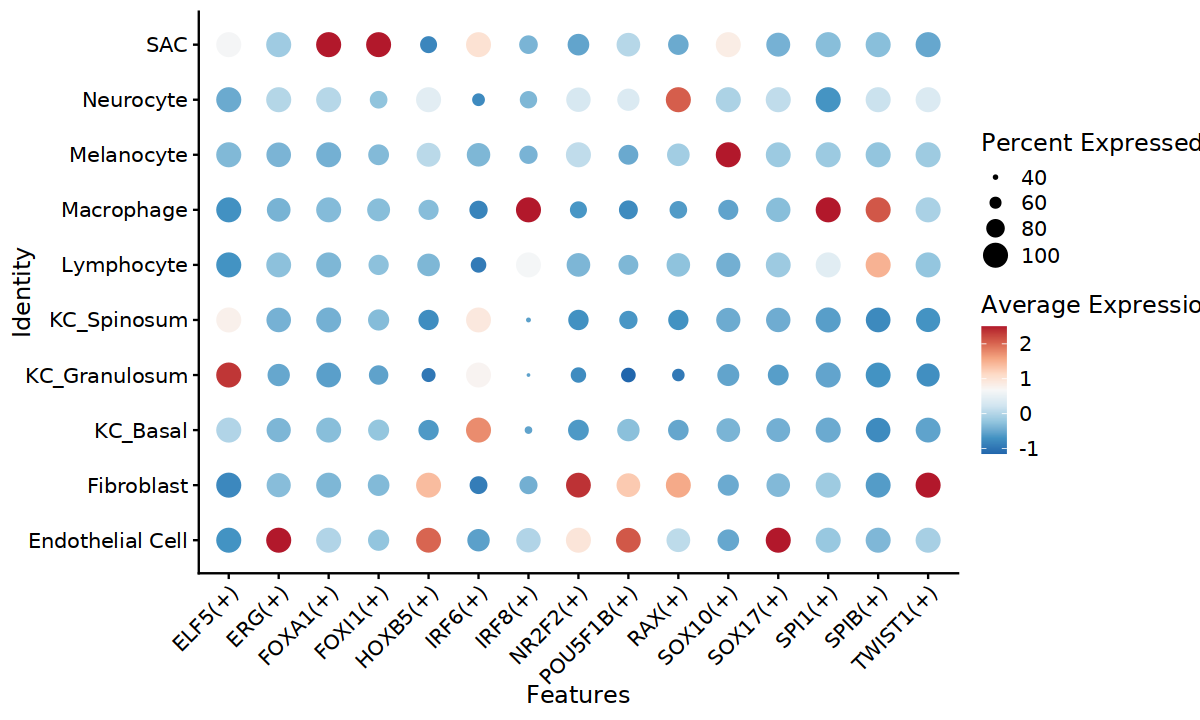

In [89]:
options(repr.plot.width = 10, repr.plot.height = 6)

Idents(obj) <- 'celltype_0818' # 记得改 Idents 如果 Idents 跟 scale_y_discrete不同，画不出来
p1 = DotPlot(obj, features = unique(row.names(sub_regulonAUC)) , cluster.idents = FALSE ) + 
             RotatedAxis() + 
             scale_color_gradientn(colours  = brewer.pal(n = 9, name = "RdBu") %>% rev()) + 
             scale_y_discrete(limits=sort(unique(obj$celltype_0818)),position = "left")
p1

ggsave('regulons_activity_in_dotplot.png', p1, width = 10, height = 6, bg = "white")

### VlnPlot & Ridgeplot

In [99]:
regulonsToPlot <- unique(row.names(sub_regulonAUC))
length(regulonsToPlot)
regulonsToPlot

[1] 15

[1] "ELF5(+)"    "ERG(+)"     "FOXA1(+)"   "FOXI1(+)"   "HOXB5(+)"  
 [6] "IRF6(+)"    "IRF8(+)"    "NR2F2(+)"   "POU5F1B(+)" "RAX(+)"    
[11] "SOX10(+)"   "SOX17(+)"   "SPI1(+)"    "SPIB(+)"    "TWIST1(+)"

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Picking joint bandwidth of 0.00414

Picking joint bandwidth of 0.00364

Picking joint bandwidth of 0.00327

Picking joint bandwidth of 0.00615

Picking joint bandwidth of 0.0037

Picking joint bandwidth of 0.00767

Picking joint bandwidth of 0.00323

Picking joint bandwidth of 0.00646

Picking joint bandwidth of 0.00529

Picking joint bandwidth of 0.00299

Picking joint bandwidth of 0.00414

Picking joint bandwidth of 0.00362

Picking joint bandwidth of 0.00241

Picking joint bandwidth of 0.00241

Picking joint bandwidth of 0.00317

Picking joint bandwidth of 0.00414

Picking joint bandwidth of 0.00364

Picking joint bandwidth of 0.00327

Picking joint bandwidth of 0.00615

Picking joint bandwidth of 0.0037

Picking joint bandwidth of 0.00767

Picking joint bandwidth of 0.00323

Picking joint bandwidth of 0.00646

Picking joint bandwidth of 0.00529

Picking joint bandwidth of 0.00299

Pic

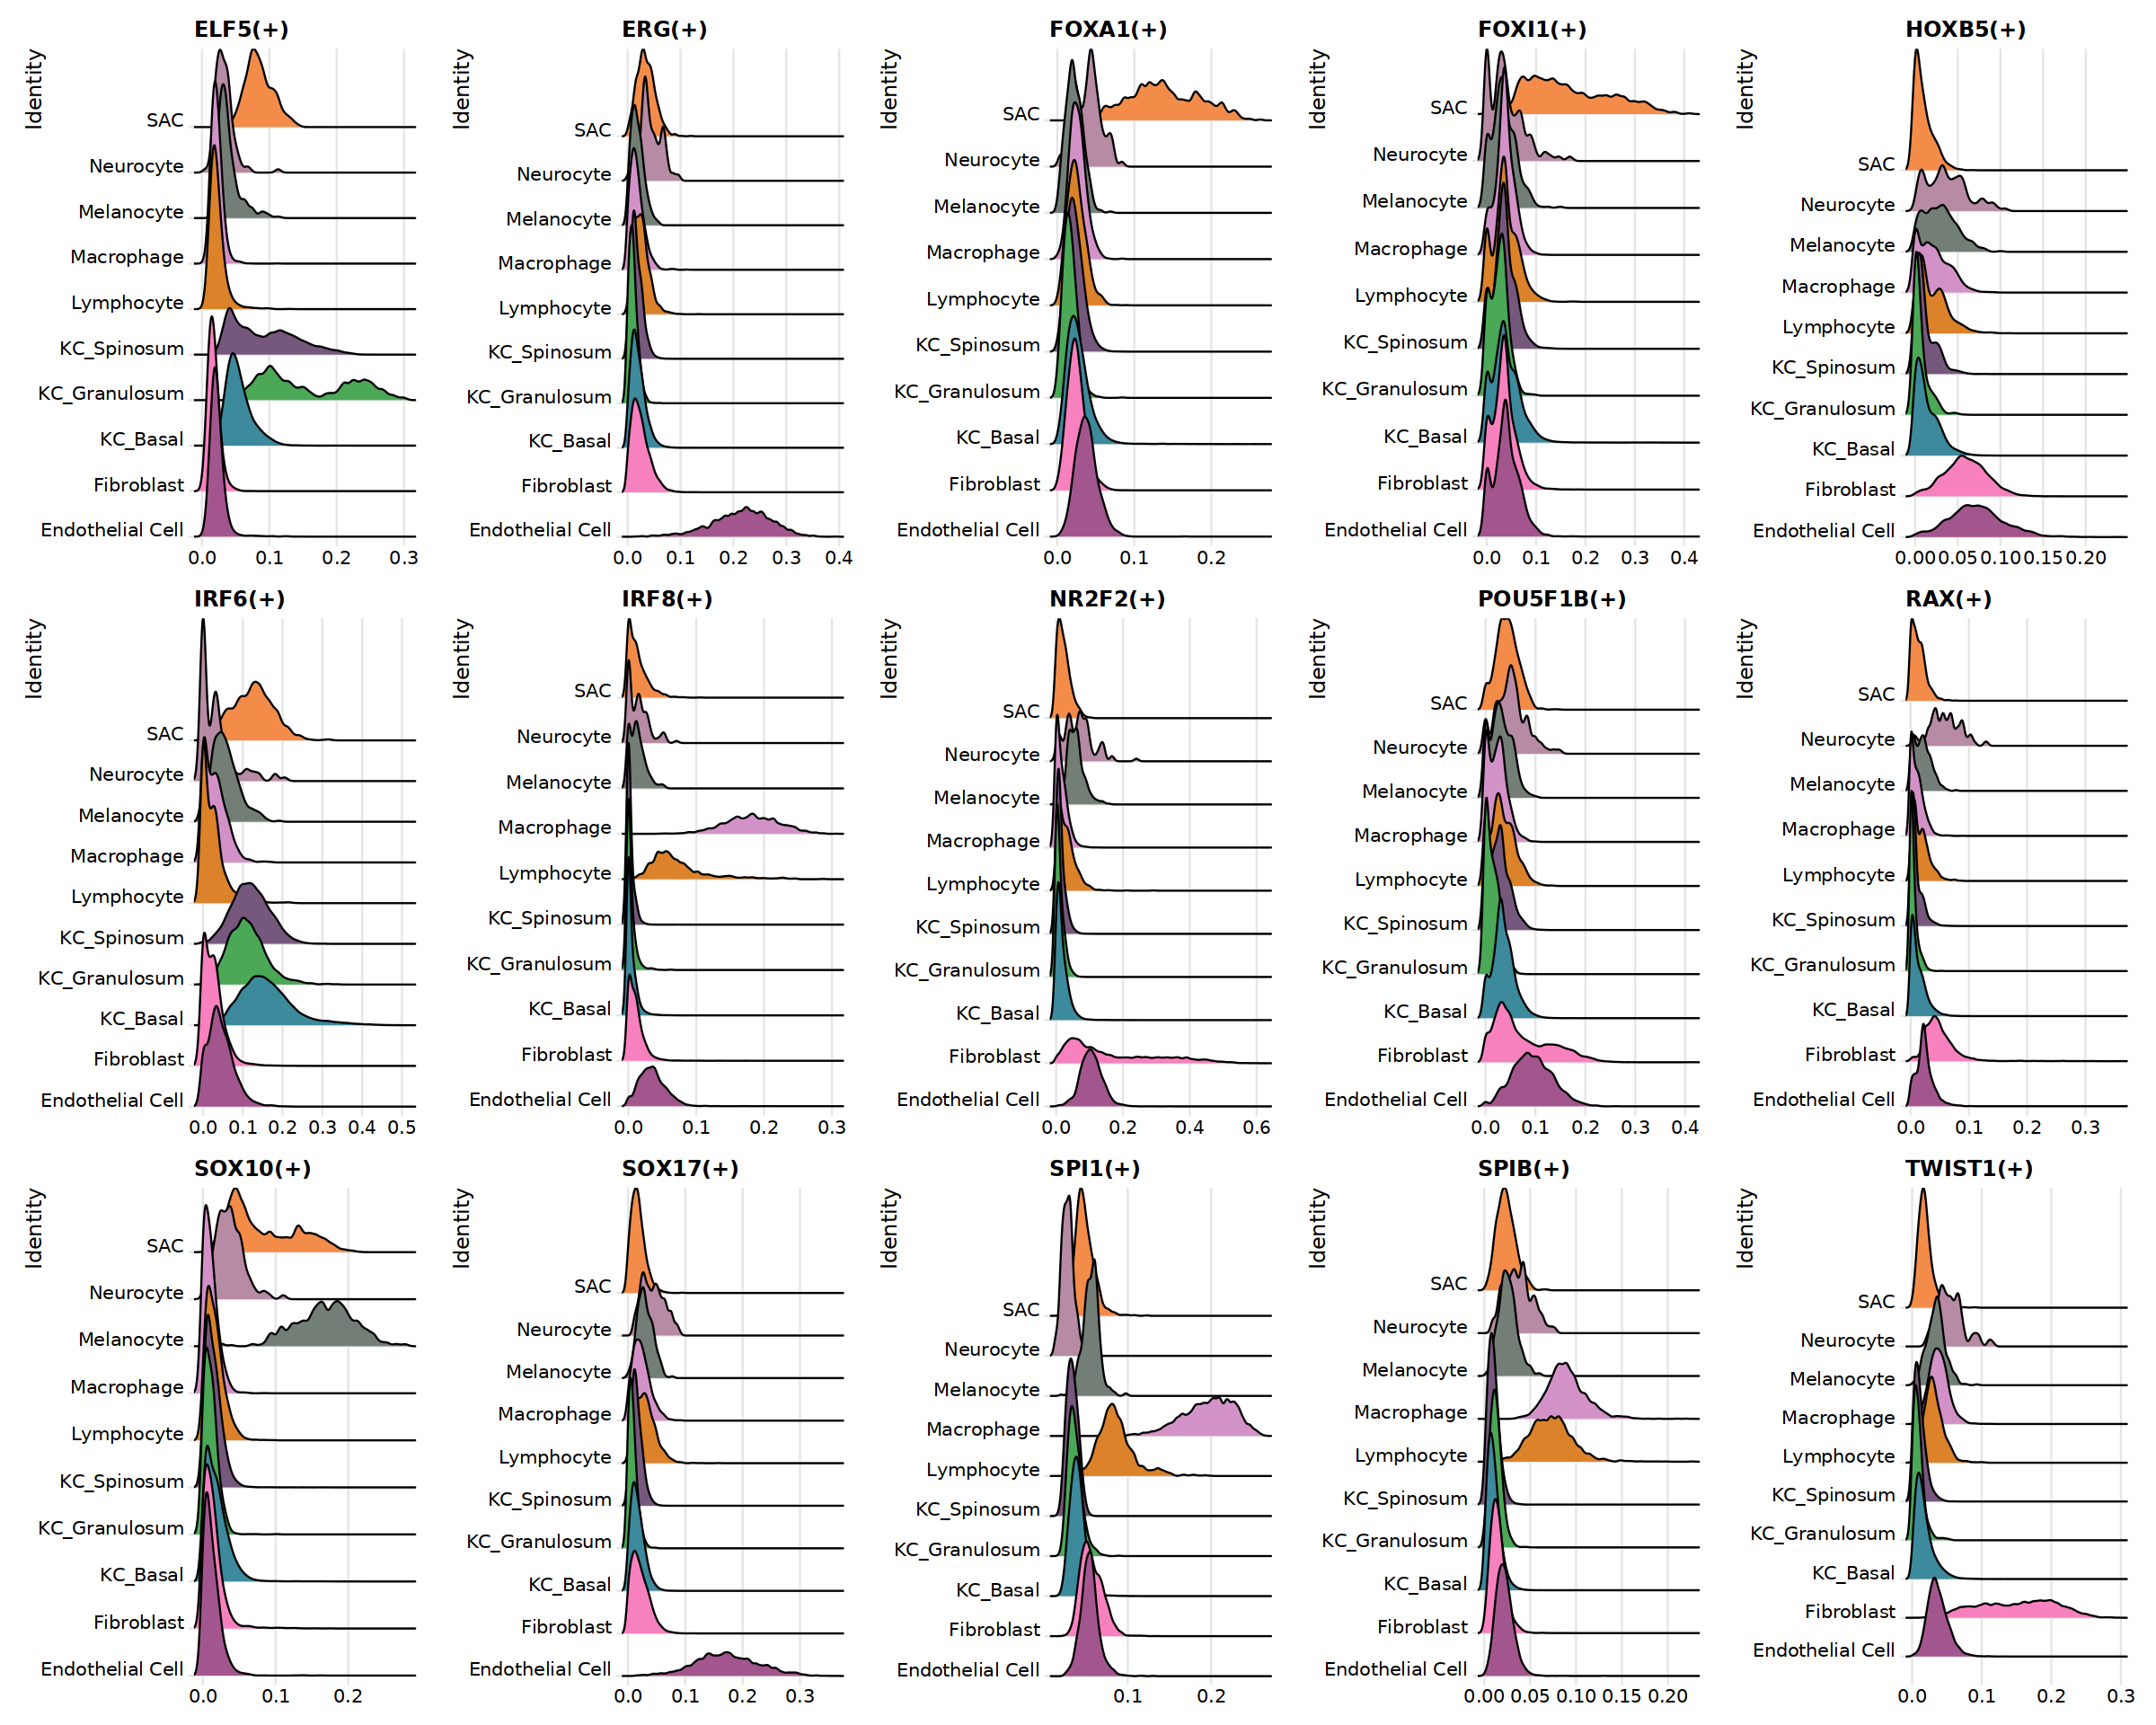

In [110]:
options(repr.plot.width = 20, repr.plot.height = 16)
p2 = RidgePlot(obj, features = regulonsToPlot , ncol = 5, cols = color) + scale_y_discrete(limits=sort(unique(obj$celltype_0818)),position = "left")
p2
ggsave('regulons_activity_in_RidgePlot.png', p2, width = 20, height = 16, bg = "white")


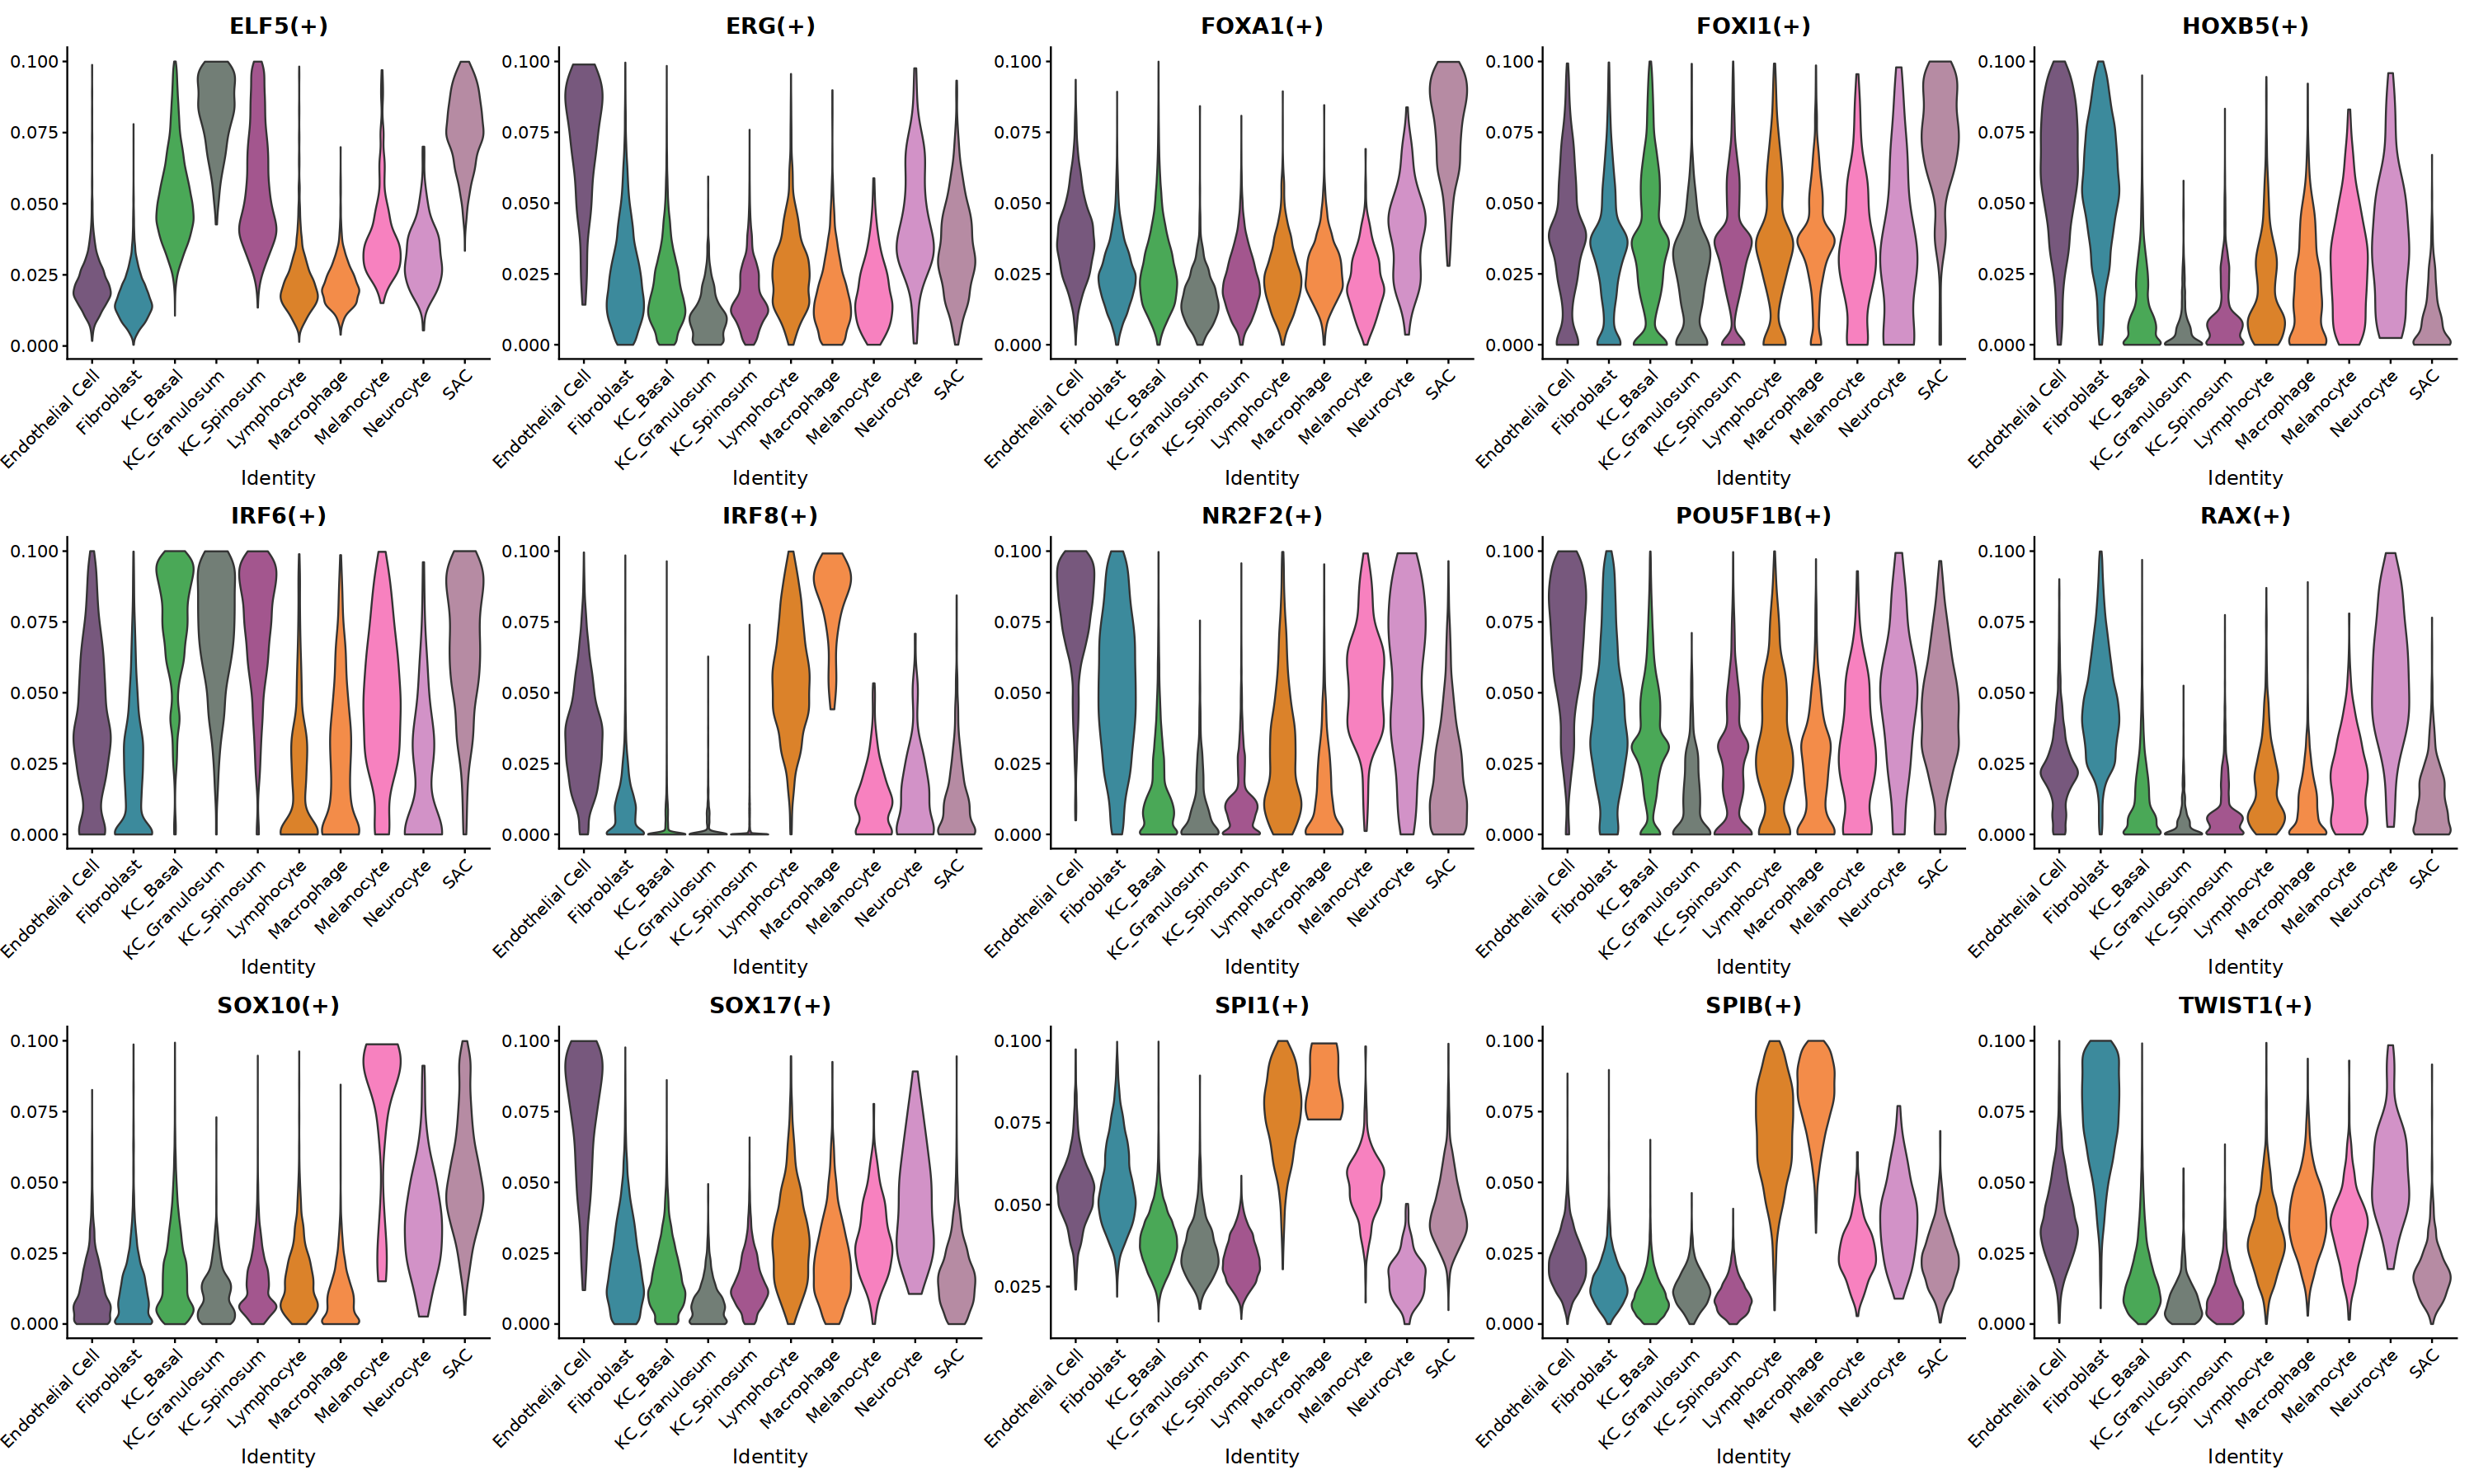

In [111]:
options(repr.plot.width = 25, repr.plot.height = 15)
p3 = VlnPlot(obj, features = regulonsToPlot, pt.size = 0, ncol = 5, cols = colors, y.max = 0.1)
p3
ggsave('regulons_activity_in_VlnPlot.png', p3, width = 25, height = 15, bg = "white")

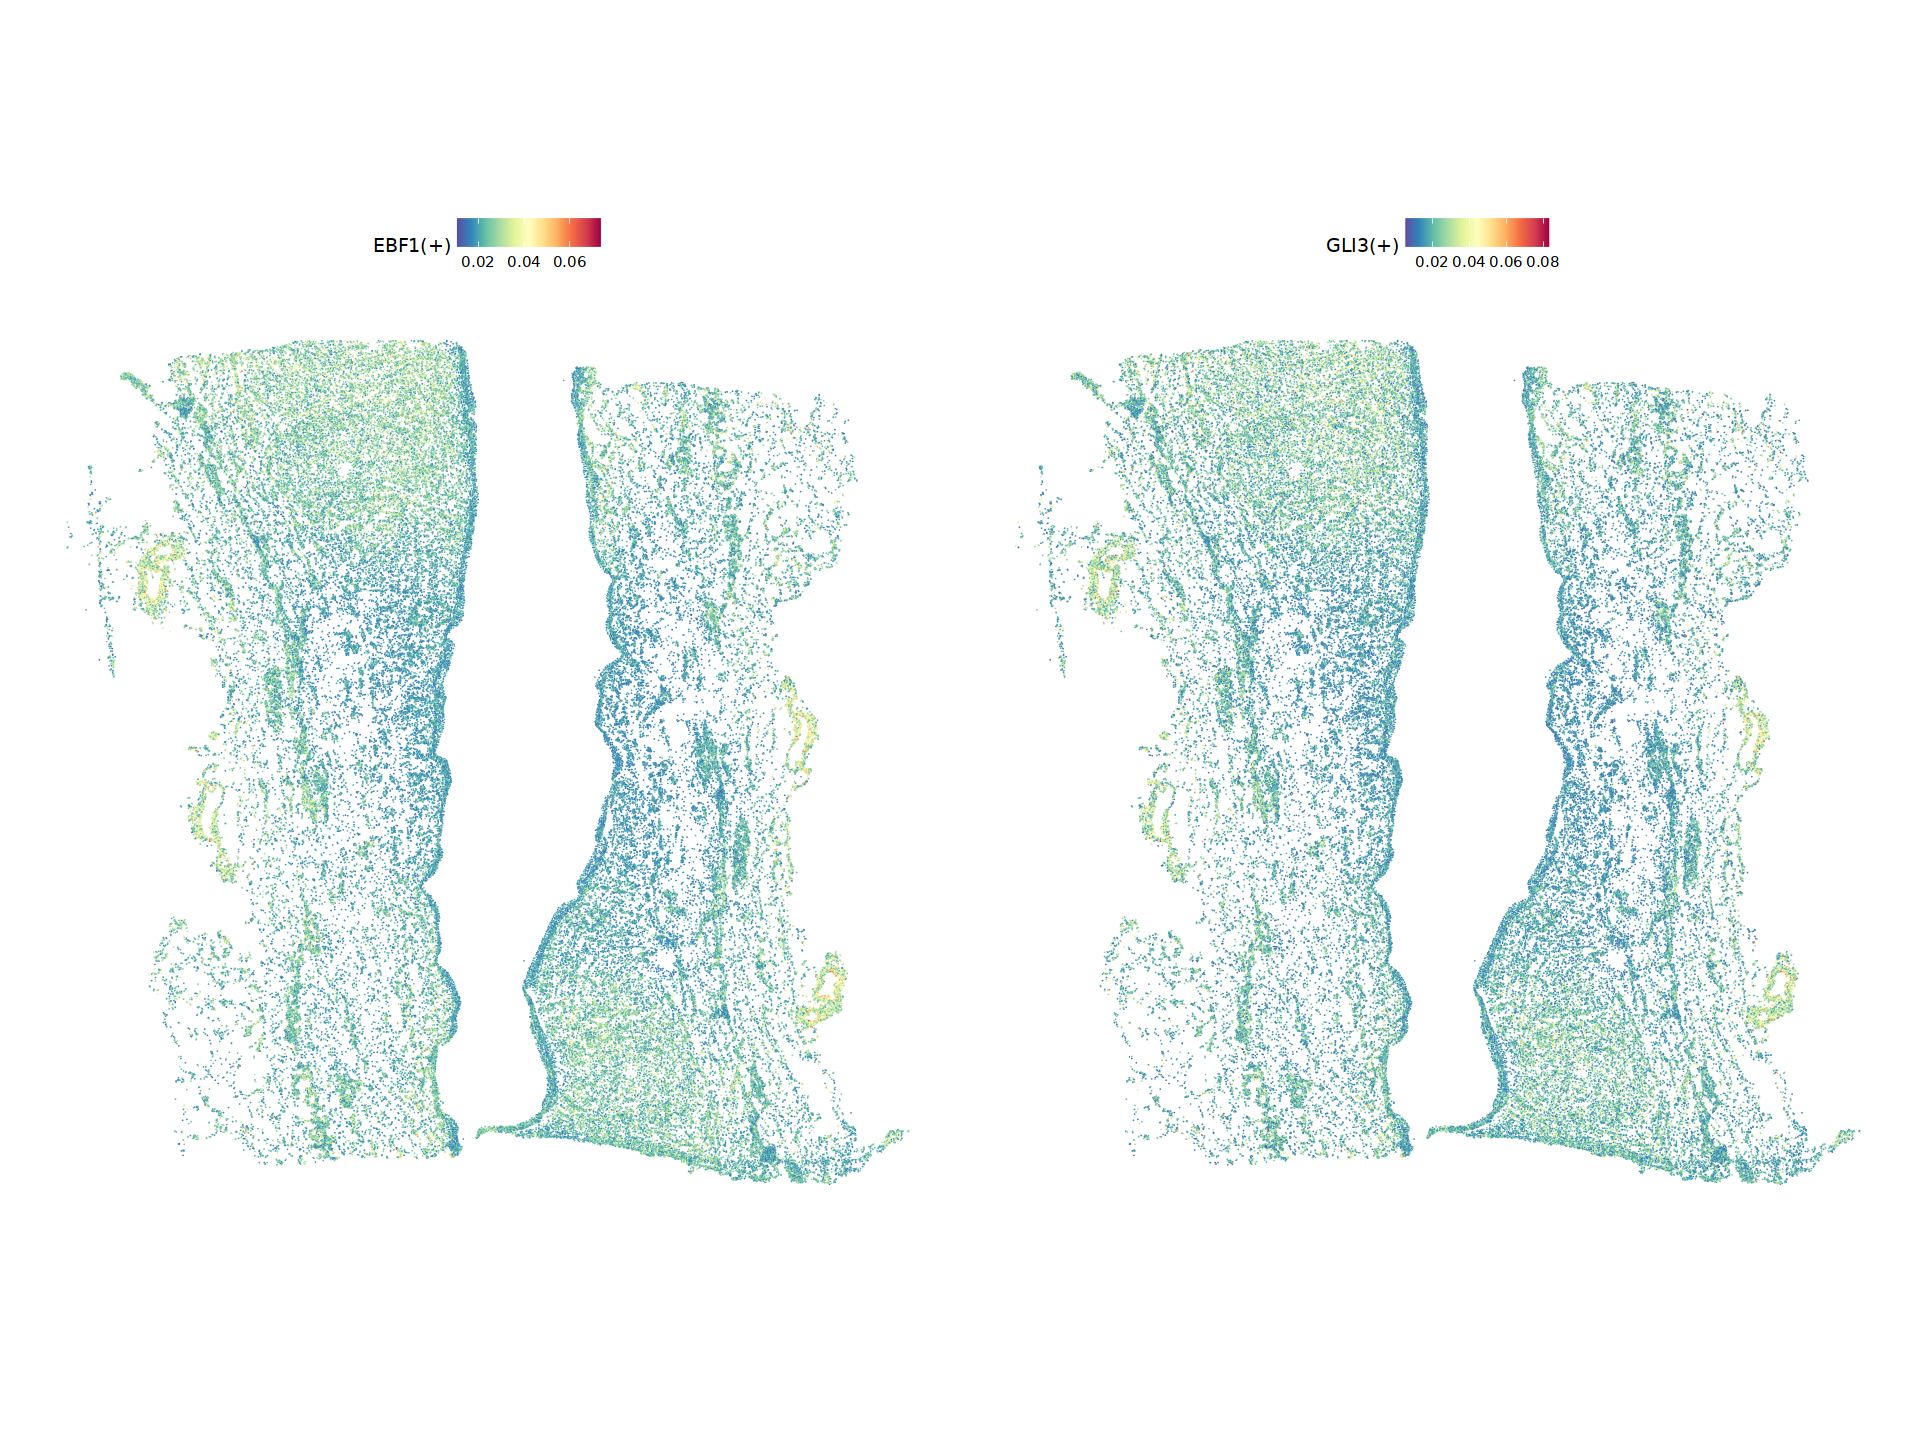

In [154]:
options(repr.plot.width = 16, repr.plot.height = 12)
p <- SpatialFeaturePlot(obj, features = regulonsToPlot, stroke = NA, pt.size.factor=20, alpha=1)
p

## 基于 RSS 和 rssPlot 作图

In [131]:
# Topic TF in RSS (rssPlot$df$Topic)

TF = rss[unique(rssPlot$df$Topic),]
head(TF)

pdf('plotRSS_in_celltype.pdf', width = 8, height = 5)
    pheatmap(TF,scale='row',show_rownames = T, main='plotRSS unique regulons')
dev.off()

KC_Spinosum KC_Basal   Fibroblast KC_Granulosum Endothelial Cell
POU5F1B(+) 0.11861787  0.36318344 0.21107106 0.014952309   0.15749456      
IRF8(+)    0.02761747  0.09964665 0.09251738 0.007984886   0.14894439      
HOXB5(+)   0.09558729  0.25015878 0.30080147 0.012474414   0.19921564      
IRF6(+)    0.19063408  0.56312933 0.04171968 0.039938447   0.03723911      
SOX17(+)   0.11579478  0.27928397 0.11684698 0.014441046   0.34737724      
FOXA1(+)   0.15179810  0.40122868 0.13093893 0.025994556   0.10373639      
           SAC        Lymphocyte Macrophage Melanocyte  Neurocyte  
POU5F1B(+) 0.04048212 0.04778149 0.03562512 0.011848738 0.006430759
IRF8(+)    0.03013336 0.18621096 0.39614519 0.012431647 0.004652068
HOXB5(+)   0.01780920 0.05010781 0.05333406 0.019012859 0.008119923
IRF6(+)    0.04167479 0.01509200 0.01864762 0.008282833 0.001642421
SOX17(+)   0.02693044 0.06477420 0.05286144 0.017479831 0.008244763
FOXA1(+)   0.13641492 0.05228268 0.05642209 0.012686203 0.007084668

pdf 
  2

In [120]:
# all TF in RSS
pdf('all_RSS_in_celltype.pdf',width = 10, height = 10)
    pheatmap(rss,scale='row',show_rownames = T,main='all regulons RSS')
dev.off()

pdf 
  2